# Sequence Learning - Direct - English - Testing Session - Phonological Testings
Version 1: We should conduct the following tests:   
1. Clustering test: i.e. for the whole bunch of phones we do a clustering task. Check the degree of alignment between clustered clusters and the ground truth tag of the tokens. 

2. of course we should plot out the phones and words to check whether they are well distinguishable from the hidden representation. 

In [1]:
import torch
import torchaudio
from torch import nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from torch import optim
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
from collections import Counter
import seaborn as sns
import pingouin as pg

from sklearn.cluster import KMeans
from sklearn.metrics import homogeneity_completeness_v_measure

In [2]:
from padding import generate_mask_from_lengths_mat, mask_it
from paths import *
from my_utils import *
from loss import *
from model import SimplerPhxLearner
from dataset import SeqDatasetAnno, MelSpecTransform
from my_dataset import DS_Tools
from reshandler import AnnoEncoderMelResHandler
from misc_progress_bar import draw_progress_bar
from bnd_detect_tools import *

## Preps

### Dirs

In [3]:
model_save_dir = model_eng_save_dir

log_path = phone_seg_anno_log_path
rec_path = phone_seg_anno_path

### Constants

In [4]:
EPOCHS = 10
BATCH_SIZE = 1

INPUT_DIM = 64
OUTPUT_DIM = 64

INTER_DIM_0 = 32
INTER_DIM_1 = 16
INTER_DIM_2 = 8

ENC_SIZE_LIST = [INPUT_DIM, INTER_DIM_0, INTER_DIM_1, INTER_DIM_2]
DEC_SIZE_LIST = [OUTPUT_DIM, INTER_DIM_0, INTER_DIM_1, INTER_DIM_2]

DROPOUT = 0.5

REC_SAMPLE_RATE = 16000
N_FFT = 400
N_MELS = 64

LOADER_WORKER = 16

## Model

### Model-related defs

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
recon_loss = nn.MSELoss(reduction='none')
masked_recon_loss = MaskedLoss(recon_loss)
model_loss = masked_recon_loss

model = SimplerPhxLearner(enc_size_list=ENC_SIZE_LIST, dec_size_list=DEC_SIZE_LIST, num_layers=2)
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

### Load Model

In [6]:
load_ts = "0926172946"
stop_epoch = "194"

In [7]:
model_raw_name = "PT_{}_{}_full".format(load_ts, stop_epoch)
model_name = model_raw_name + ".pt"
model_path = os.path.join(model_save_dir, model_name)
state = torch.load(model_path)

model.load_state_dict(state)
model.to(device)

SimplerPhxLearner(
  (encoder): RLEncoder(
    (rnn): LSTM(64, 16, num_layers=2, batch_first=True)
    (lin_2): LinearPack(
      (linear): Linear(in_features=16, out_features=8, bias=True)
      (relu): Tanh()
      (dropout): Dropout(p=0.5, inplace=False)
    )
  )
  (decoder): RALDecoder(
    (rnn): LSTM(64, 8, num_layers=2, batch_first=True)
    (attention): ScaledDotProductAttention(
      (w_q): Linear(in_features=8, out_features=8, bias=True)
      (w_k): Linear(in_features=8, out_features=8, bias=True)
      (w_v): Linear(in_features=8, out_features=8, bias=True)
    )
    (lin_3): LinearPack(
      (linear): Linear(in_features=8, out_features=64, bias=True)
      (relu): Tanh()
      (dropout): Dropout(p=0.5, inplace=False)
    )
  )
)

### Dataset

- Note that due to the separate setting of word and phone datasets, we cannot really make it to select those that have not been trained on 
for this test. This is a point to further fix. Make reference to out first work. 

In [8]:
mytrans = MelSpecTransform(sample_rate=REC_SAMPLE_RATE, n_fft=N_FFT, n_mels=N_MELS)
ds = SeqDatasetAnno(rec_path, os.path.join(log_path, "log.csv"), transform=mytrans)

# # this is to reduce the size of the dataset when the training power is not sufficient
small_len = int(0.05 * len(ds))
other_len = len(ds) - small_len

# # Randomly split the dataset into train and validation sets
valid_ds, other_ds = random_split(ds, [small_len, other_len])

valid_loader = DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=LOADER_WORKER, collate_fn=SeqDatasetAnno.collate_fn)
valid_num = len(valid_loader.dataset)

In [9]:
valid_num

41640

## Inference

In [10]:
def infer(): 
    model.eval()
    reshandler = AnnoEncoderMelResHandler(whole_res_dir=cluster_res_path, file_prefix=model_raw_name)
    all_res = []
    all_token = []
    all_input = []

    total = len(valid_loader)

    for idx, (x, x_lens, token, name) in enumerate(valid_loader): 
        token = token[0]

        x_mask = generate_mask_from_lengths_mat(x_lens, device=device)
        
        x = x.to(device)

        hid_r = model.encode(x, x_lens, x_mask)

        hid_r = hid_r.cpu().detach().numpy().squeeze()
        # input_r = x.cpu().detach().numpy().squeeze()

        length = hid_r.shape[0]

        all_res.append(hid_r)
        all_token.append(token)
        # all_input = np.concatenate((all_input, input_r), axis=0)

        if idx % 10 == 0: 
            draw_progress_bar(idx, total)
    

    reshandler.res = all_res
    reshandler.tok = all_token
    reshandler.transformed = all_input
    reshandler.save()

In [11]:
if __name__ == "__main__": 
    infer()

[==================================================] 99%	

# Load Res

In [12]:
reshandler = AnnoEncoderMelResHandler(whole_res_dir=cluster_res_path, file_prefix=model_raw_name)
reshandler.read()

# Cluster Evaluation

In [13]:
# all
all_res = reshandler.res
all_tokens = reshandler.tok
# all_inputs = reshandler.transformed

In [14]:
def concat(res, tok, method="all"): 
    if method == "all": 
        concat_res = np.concatenate(res, axis=0)
        concat_tok = []
        for i in range(len(tok)): 
            concat_tok += [tok[i]] * res[i].shape[0]
        return concat_res, concat_tok
    
    elif method == "last": 
        target_res = [arr[-1:, :] for arr in all_res]
        concat_res = np.concatenate(target_res, axis=0)
        concat_tok = tok
        return concat_res, concat_tok
    
    elif method == "mean": 
        target_res = [np.sum(arr, axis=0, keepdims=True) for arr in all_res]
        concat_res = np.concatenate(target_res, axis=0)
        concat_tok = tok
        return concat_res, concat_tok

In [15]:
concat_res, concat_tok = concat(all_res, all_tokens, method="last")

In [16]:
num_phones = np.unique(all_tokens).shape[0]

### Hidden representation

In [30]:
kmeansmodel = KMeans(n_clusters=num_phones) # , random_state=0
clusters = kmeansmodel.fit_predict(concat_res)

/home/ldlmdl/anaconda3/envs/wavln/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [31]:
h, c, v = homogeneity_completeness_v_measure(concat_tok, clusters)
print(h, c, v)

0.09159004062611534 0.08865767756983192 0.0901000064989507


### Baseline: uniformly randomly draw from the 63 phones categories

In [32]:
clusters_base = np.random.randint(0, num_phones, size=concat_res.shape[0])

In [33]:
hb, cb, vb = homogeneity_completeness_v_measure(concat_tok, clusters_base)
print(hb, cb, vb)

0.010827301975308247 0.009331061463533212 0.010023653013534735


In [34]:
v/vb

8.988739572019352

# Significance Test & Dist

In [17]:
import numpy as np
from scipy.stats import f, chi2, multivariate_normal
from scipy.spatial import distance
from itertools import combinations
from scipy.stats import pearsonr

In [18]:
def dataframe_to_phonological_dict(df):
    phonological_dict = {}
    for index, row in df.iterrows():
        symbol = row['symbol']
        phonological_vector = np.array(row.iloc[2:], dtype=int)
        phonological_dict[symbol] = phonological_vector
    return phonological_dict

In [19]:
mapper = pd.read_csv("english_to_feats.csv")

In [20]:
mapperdict = dataframe_to_phonological_dict(mapper)

In [21]:
def count_instances(token, all_tokens): 
    return np.sum(np.array(all_tokens) == token)

def filter_by_count(the_tokens, all_tokens, th): 
    filtered_tokens = []
    for token in the_tokens: 
        if count_instances(token, all_tokens) < th: 
            continue
        filtered_tokens.append(token)
    return np.array(filtered_tokens)

In [22]:
def edit_dist(a, b): 
    # a, b being numpy arrays
    return np.sum(a != b)

In [23]:
def filter_by_label(res, tok, label): 
    mask = np.array(tok) == label
    return res[mask]

In [24]:
def HT(group_a, group_b): 
    # Compute the means for each group
    mean_group1 = np.mean(group_a, axis=0)
    mean_group2 = np.mean(group_b, axis=0)

    # Compute the sample covariance matrices for each group
    cov_group1 = np.cov(group_a, rowvar=False)
    cov_group2 = np.cov(group_b, rowvar=False)

    # Number of observations in each group
    n1 = len(group_a)
    n2 = len(group_b)

    # Combine the covariance matrices using a pooled estimator
    pooled_cov = ((n1 - 1) * cov_group1 + (n2 - 1) * cov_group2) / (n1 + n2 - 2)

    # Calculate Hotelling's T-squared statistic
    t_squared = n1 * n2 / (n1 + n2) * (mean_group1 - mean_group2).T @ np.linalg.inv(pooled_cov) @ (mean_group1 - mean_group2)

    # Define degrees of freedom for the F-distribution
    df1 = len(group_a[0])  # Number of variables
    df2 = n1 + n2 - df1 - 1

    # Calculate the critical value for the F-distribution
    alpha = 0.05  # significance level
    critical_value = f.ppf(1 - alpha, df1, df2)

    # Perform the Hotelling's T-squared test
    p_value = 1 - f.cdf(t_squared, df1, df2)

    return p_value


In [25]:
def dist_calc(a, b): 
    ca = np.cov(a.T)
    cb = np.cov(b.T)
    iv = np.linalg.inv((ca + cb) / 2)
    dist = distance.mahalanobis(np.average(a, axis=0), np.average(b, axis=0),iv)
    return dist

In [26]:
filter_by_count(np.unique(all_tokens), all_tokens, th=100)

array(['aa', 'ae', 'ah', 'ao', 'aw', 'ay', 'b', 'ch', 'd', 'dh', 'dx',
       'eh', 'el', 'em', 'en', 'er', 'ey', 'f', 'g', 'hh', 'ih', 'iy',
       'jh', 'k', 'l', 'm', 'n', 'ng', 'nx', 'ow', 'p', 'r', 's', 'sh',
       't', 'th', 'tq', 'uh', 'uw', 'v', 'w', 'y', 'z'], dtype='<U2')

In [27]:
res_pair = []
res_editdiff = []
res_groupdist = []

pairs = list(combinations(np.intersect1d(filter_by_count(np.unique(all_tokens), all_tokens, th=100), np.array(list(mapperdict.keys()))), 2))
for pair in pairs: 
    label_a, label_b = pair
    editdiff = edit_dist(mapperdict[label_a], mapperdict[label_b])
    group_a = filter_by_label(concat_res, concat_tok, label=label_a)
    group_b = filter_by_label(concat_res, concat_tok, label=label_b)
    groupdist = dist_calc(group_a, group_b)

    if math.isnan(groupdist): 
        print(pair, groupdist)
        continue


    res_pair.append(pair)
    res_editdiff.append(editdiff)
    res_groupdist.append(groupdist)

In [28]:
len(res_pair)

903

In [29]:
correlation, p_value = pearsonr(res_editdiff, res_groupdist)

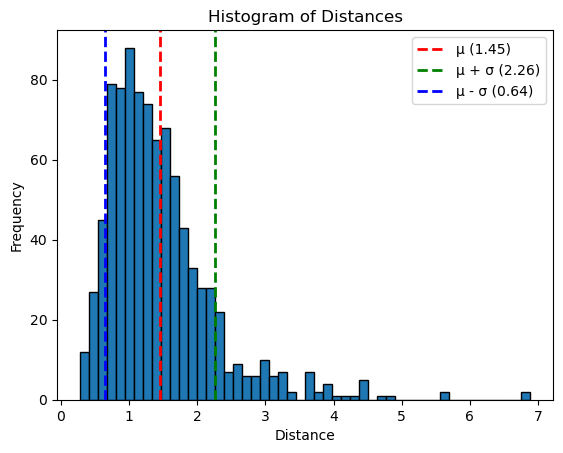

In [30]:
# Create a histogram
plt.hist(res_groupdist, bins=50, edgecolor='black')
plt.title("Histogram of Distances")
plt.xlabel("Distance")
plt.ylabel("Frequency")

# Calculate mean and standard deviation
mean = np.mean(res_groupdist)
std_dev = np.std(res_groupdist)

# Add vertical lines for mean and mean plus/minus std dev
plt.axvline(mean, color='red', linestyle='dashed', linewidth=2, label=f"μ ({mean:.2f})")
plt.axvline(mean + std_dev, color='green', linestyle='dashed', linewidth=2, label=f"μ + σ ({mean + std_dev:.2f})")
plt.axvline(mean - std_dev, color='blue', linestyle='dashed', linewidth=2, label=f"μ - σ ({mean - std_dev:.2f})")

# Show the legend
plt.legend()

# Show the histogram
plt.show()

In [31]:
correlation, p_value

(0.19169736695983908, 6.381106565355024e-09)

In [32]:
top_indices = np.argsort(-np.array(res_groupdist))[:10]
np.array(res_pair)[top_indices]

array([['aw', 'dx'],
       ['aw', 'nx'],
       ['dx', 'sh'],
       ['nx', 'sh'],
       ['ay', 'dx'],
       ['ay', 'nx'],
       ['ae', 'dx'],
       ['ch', 'nx'],
       ['ch', 'dx'],
       ['ae', 'nx']], dtype='<U2')

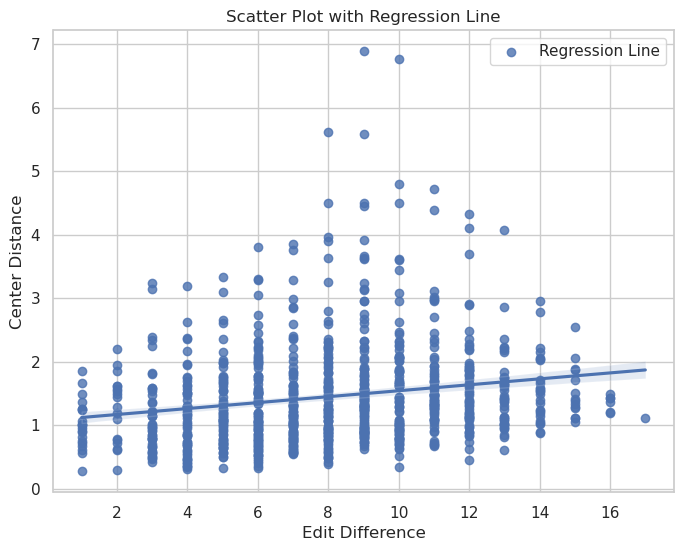

In [33]:
sns.set(style="whitegrid")  # Choose a style for the plot (optional)
plt.figure(figsize=(8, 6))  # Set the figure size (optional)
# sns.scatterplot(x=res_editdiff, y=res_groupdist, label="Data points")

# Add a regression line
sns.regplot(x=res_editdiff, y=res_groupdist, scatter=True, label="Regression Line")

# Set labels and title
plt.xlabel("Edit Difference")
plt.ylabel("Center Distance")
plt.title("Scatter Plot with Regression Line")

# Add a legend
plt.legend()

# Show the plot
plt.show()


# Phone Plot

In [34]:
def counter_to_text(res): 
    text = ""
    for item, count in res.items():
        text += f"{item}: {count}; "
    
    return text

In [35]:
def select(data, guide, selector):
    # Ensure that the lengths of annotations and data_array match
    if len(guide) != data.shape[0]:
        raise ValueError("The length of guide must match the number of items in the data.")

    # Create a boolean mask for selected annotations
    mask = np.isin(guide, selector)

    # Use the mask to select the corresponding items from the data array
    selected_items = data[mask]

    return selected_items

In [37]:
top_indices = np.argsort(-np.array(res_groupdist))

In [39]:
plt.ioff()
length = len(top_indices)
for rank, pid in enumerate(top_indices): 
    cluster_groups = res_pair[pid]

    hidr_cs = select(data=concat_res, 
                    guide=concat_tok, 
                    selector=cluster_groups)
    tags_cs = select(data=np.array(concat_tok), 
                    guide=concat_tok, 
                    selector=cluster_groups)
    color_translate = {item: idx for idx, item in enumerate(cluster_groups)}

    # Use Counter to count the occurrences of each item
    item_counts = Counter(tags_cs)

    X = hidr_cs
    y = tags_cs

    colors = [color_translate[item] for item in y]
    df = pd.DataFrame(X)
    df["tag"] = y

    sns.set(style="ticks", color_codes=True)
    g = sns.PairGrid(df, hue="tag", diag_sharey=False)
    g.fig.tight_layout(rect=[0, 0.03, 1, 0.97])
    # g = sns.pairplot(df,hue='tag', diag_kind="kde", plot_kws=dict(alpha=0.3))
    g.map_lower(sns.scatterplot, alpha=0.3)
    g.map_diag(sns.histplot, kde=True, alpha=.4)
    g.map_upper(sns.kdeplot, levels=10, fill=True, alpha=0.7)

    handles = g._legend_data.values()
    labels = g._legend_data.keys()
    g.fig.legend(handles=handles, labels=labels, loc='lower center', ncol=2)

    g.fig.suptitle("Rank = {rank}; Edit_d = {ed}; Center_d = {cd:.4f}; {counts}".format(rank=rank, ed=res_editdiff[pid], cd=res_groupdist[pid], counts=counter_to_text(item_counts)))

    plt.savefig(os.path.join(phone_plot_path, "{}-{}.png".format(rank, "-".join(cluster_groups))), dpi=300)
    draw_progress_bar(rank, length)

[=                                                 ] 1%	

/home/ldlmdl/anaconda3/envs/wavln/lib/python3.11/site-packages/seaborn/axisgrid.py:1274: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=figsize)


[============                                      ] 23%	

KeyboardInterrupt: 

In [178]:
# get usable cluster groups
cluster_groups = ('aw', 'b')

hidr_cs = select(data=concat_res, 
                 guide=concat_tok, 
                 selector=cluster_groups)
tags_cs = select(data=np.array(concat_tok), 
                 guide=concat_tok, 
                 selector=cluster_groups)
color_translate = {item: idx for idx, item in enumerate(cluster_groups)}

# Use Counter to count the occurrences of each item
item_counts = Counter(tags_cs)

# Print the item counts
for item, count in item_counts.items():
    print(f"{item}: {count}")

b: 833
aw: 253


In [204]:
list(item_counts.items())

[('b', 833), ('aw', 253)]

ValueError: 'right center' is not a valid value for loc; supported values are 'best', 'upper right', 'upper left', 'lower left', 'lower right', 'right', 'center left', 'center right', 'lower center', 'upper center', 'center'

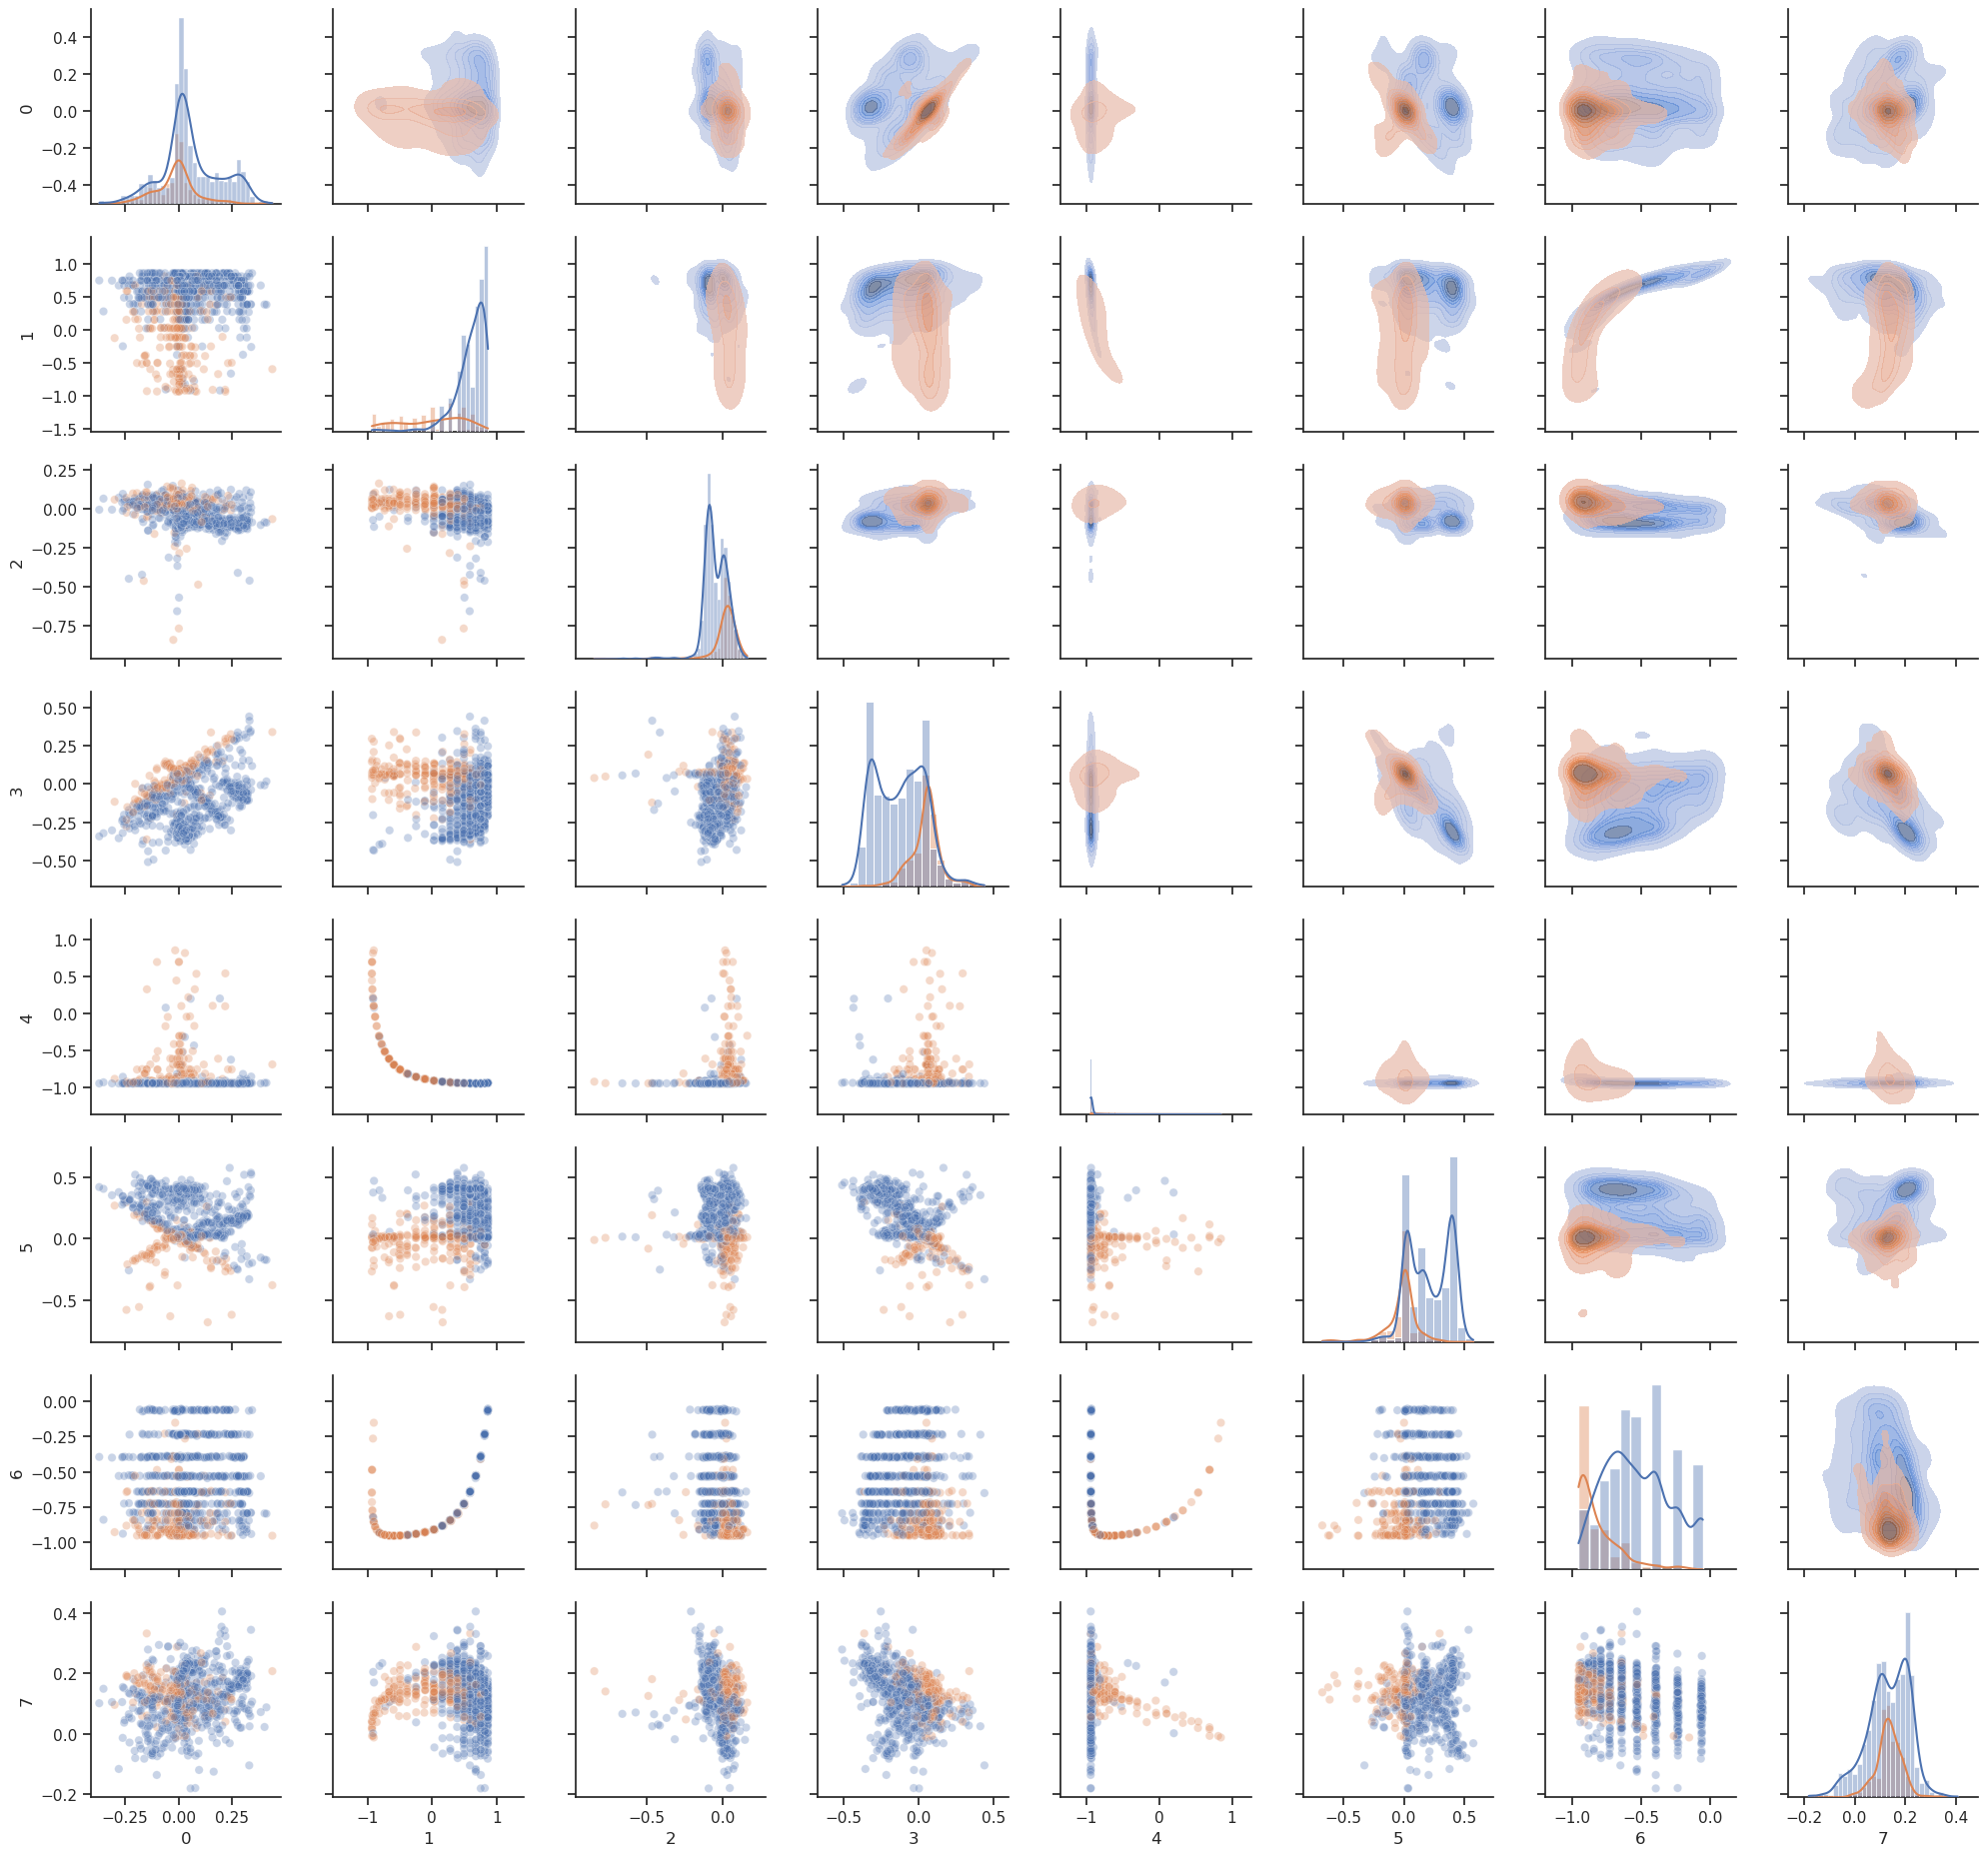

In [198]:
X = hidr_cs
y = tags_cs

colors = [color_translate[item] for item in y]
df = pd.DataFrame(X)
df["tag"] = y

sns.set(style="ticks", color_codes=True)
g = sns.PairGrid(df, hue="tag", diag_sharey=False)
g.fig.tight_layout(rect=[0, 0.03, 1, 0.97])
# g = sns.pairplot(df,hue='tag', diag_kind="kde", plot_kws=dict(alpha=0.3))
g.map_lower(sns.scatterplot, alpha=0.3)
g.map_diag(sns.histplot, kde=True, alpha=.4)
g.map_upper(sns.kdeplot, levels=10, fill=True, alpha=0.7)

handles = g._legend_data.values()
labels = g._legend_data.keys()
g.fig.legend(handles=handles, labels=labels, loc='center right', ncol=2)
g.fig.suptitle("Rank = {rank}; Edit_d = {ed}; Center_d = {cd}; ".format(rank=1, ed=2, cd=3))

plt.savefig(os.path.join(phone_plot_path, "{}.png".format("-".join(cluster_groups))), dpi=300)